In [1]:
from rnamodif.util_notebooks.explore import plot_avg_lengths, plot_reads, get_read_lengths, plot_len_dist, get_lengths_df

# Signal and cutoff exploration

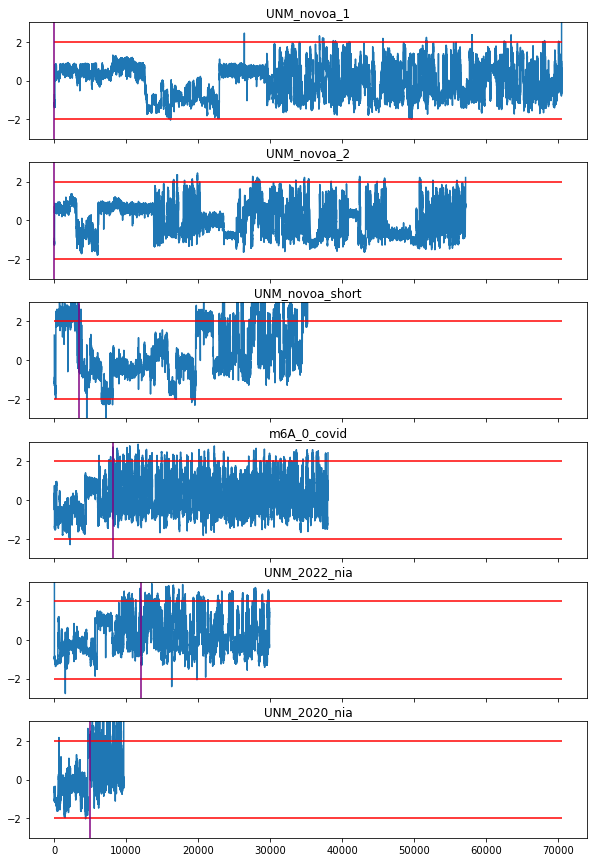

In [2]:
# novoa_exps = ['m6a_novoa_1','m6a_novoa_2','m6A_5_covid', 'm6A_10_covid']
novoa_exps = ['UNM_novoa_1','UNM_novoa_2','UNM_novoa_short','m6A_0_covid','UNM_2022_nia','UNM_2020_nia']
plot_reads(novoa_exps, y_axis_lim=[-3,3])

#TODO explore datamodule (load parts and visualize them)

# Read lengths exploration

EXP 2-OmeATP_0 done
EXP 2-OmeATP_10 done


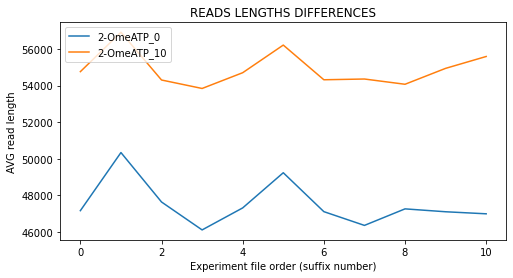

In [14]:
plot_avg_lengths(get_read_lengths(['2-OmeATP_0','2-OmeATP_10']))

In [4]:
from rnamodif.data_utils.datamap import experiment_files
experiment_files.keys()

dict_keys(['5eu_2022', 'UNM_2022', '5eu_2020', 'UNM_2020', 'remdesivir_33', 'ac4C_10', '2-OmeATP_10', 'remdesivir_0', 's4U_33', 's4U_5', 'm5C_10', 'm5C_5', '2-OmeATP_0', 's4U_0', 'm6A_33', 'ac4C_33', '2-OmeATP_5', 'remdesivir_5', 's4U_10', 'm5C_0', 'm6A_5', 'm6A_0', 'ac4C_0', 'm6A_10', 'm5c_novoa', 'm6a_novoa_1', 'm6a_novoa_2', 'UNM_novoa_1', 'UNM_novoa_2', 'UNM_novoa_short', '5eu_nanoid_24h', '5eu_nanoid_1h', '5eu_nanoid_mix', '5eu_nanoid_neg', 'empty'])

# Lengths distribution across labels 

s4U_0 max length 335260
s4U_5 max length 260738
s4U_33 max length 328571


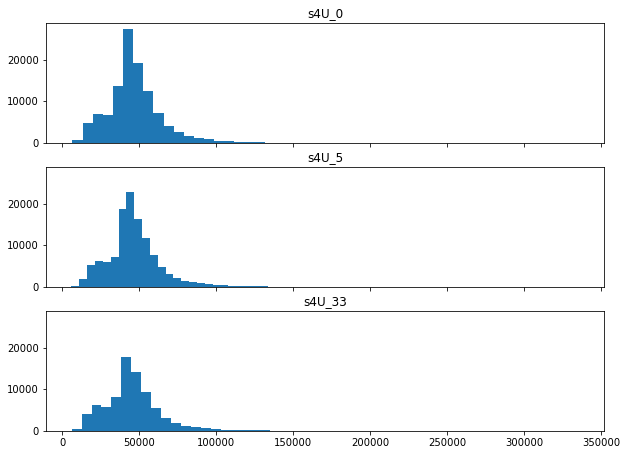

In [2]:
plot_len_dist(['s4U_0','s4U_5', 's4U_33'], get_lengths_df(), False)